# Only use competicion data for both fine-tuning and final classification

Data used for fine-tuning and final classification :

* corpus completo 5 temas - 08-sep-2016 - codificacion 5 temas.csv (competition)

In [78]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
from fastai.text import *
import html
import json

import pandas as pd
import numpy as np

pd.set_option('display.max_colwidth', -1)
np.set_printoptions(threshold=np.nan)


In [79]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

DATA_PATH=Path('./data/election_tweets')

WIKILM_PATH=Path('./language_model_wiki/LM')

TWEETSLM_PATH=Path('./LM_tweets')

TWEETSLM_PATH_0=Path('./LM_tweets_0')

CLAS_PATH=Path('./tweets_class')

## Fintune with 

In [80]:
df = pd.read_csv(DATA_PATH/'corpus_completo_5_temas_08-sep-2016-codificacion_5_temas.csv')

In [81]:
print(df.shape)
print(df.columns.values)
print(df['Texto'].isnull().any())
print(df['Tema_05'].isnull().any())
print(df['Tema_05'].value_counts())

(3116, 5)
['Num' 'Id Tweet' 'Fecha Publicacion' 'Texto' 'Tema_05']
False
False
2     1102
1     738 
9     718 
11    359 
10    199 
Name: Tema_05, dtype: int64


#### Upsample to balance dataset

In [82]:
lst = [df]
max_size = df['Tema_05'].value_counts().max()
for class_index, group in df.groupby('Tema_05'):
    lst.append(group.sample(max_size-len(group), replace=True))
df = pd.concat(lst)
print(df['Tema_05'].value_counts())

11    1102
10    1102
2     1102
9     1102
1     1102
Name: Tema_05, dtype: int64


In [83]:
tweets = df['Texto'].values
labels = df['Tema_05'].values
LABELS = set(labels)

In [84]:
def flattern(A):
    'Source: https://stackoverflow.com/a/17867797/7273299'
    
    'Flattens a list of lists and strings into a list.'
    rt = []
    for i in A:
        if isinstance(i,list): rt.extend(flattern(i))
        else: rt.append(i)
    return rt

In [85]:
# Placeholders for hyperlinks and user references
tweets = [['hyp_link' if i.startswith('http') 
           else 'user_ref' if i.startswith('@') 
           else i for i in tweet.split()] for tweet in tweets]
tweets = np.array([' '.join(i) for i in tweets])

In [86]:
# Prefix for Hashtags
tweets = [[['hash_tag', i] if i.startswith('#') else i for i in tweet.split()] for tweet in tweets]
tweets = np.array([flattern(tweet) for tweet in tweets])
tweets = np.array([' '.join(i) for i in tweets])

In [87]:
def isInt(v):
    'Source: https://stackoverflow.com/a/9859202/7273299'
    
    'Checks if a string is a number.'
    try:     i = int(v)
    except:  return False
    return True

In [88]:
# Prefix for integers
tweets = [[['int_string', i] if isInt(i) else i for i in tweet.split()] for tweet in tweets]
tweets = np.array([flattern(tweet) for tweet in tweets])
tweets = np.array([' '.join(i) for i in tweets])

In [89]:
# Prefix for slang
tweets = [[['que', 'slang_string'] if i=='q' else ['por', 'slang_string'] if i=='x' else ['de', 'slang_string'] if i=='d' else ['Que', 'slang_string'] if i=='Q' else ['Por', 'slang_string'] if i=='X' else ['De', 'slang_string'] if i=='D' else i for i in tweet.split()] for tweet in tweets]
tweets = np.array([flattern(tweet) for tweet in tweets])
tweets = np.array([' '.join(i) for i in tweets])

In [90]:
def char_count(word, chars, lbound=2):
    char_count = [word.count(char) for char in chars]
    return all(i >= lbound for i in char_count)

def replace_lol(repl_str, texts):
    for string, chars in repl_str:
        texts = [[[string, i] if char_count(i, set(chars), 2) else i for i in text.split()] for text in texts]
        texts = np.array([flattern(text) for text in texts])
        texts = np.array([' '.join(text) for text in texts])
    return texts

In [91]:
# Lol type characters
repl_str = [('risa_ja','ja'), ('risa_ji','ji'), ('risa_je','je'), ('risa_jo','jo'), ('risa_ju', 'ju')]

# Adding prefix to lol type characters
tweets = replace_lol(repl_str, tweets)

In [92]:
#shuffle
np.random.seed(42)

trn_idx = np.random.permutation(len(tweets))

tweets = tweets[trn_idx]
labels = labels[trn_idx]

In [93]:
col_names = ['label', 'tweet']

In [94]:
print(tweets[:15])

['RT user_ref .@Albert_Rivera "C\'s está en todas las encuestas por delante del PSOE,la última user_ref hoy" hash_tag #7DElDebateDecisivo hyp_link'
 'RT user_ref Rajoy llamando Ley mordaza a la ley mordaza hash_tag #L6Ncallerajoy'
 'RT user_ref user_ref user_ref user_ref user_ref user_ref user_ref Que Pablo se corta la melena ..…'
 'RT user_ref El individuo que ha agredido a Rajoy me había amenazado de muerte... acabar con estas actitudes es cosa de todos. hyp_link'
 'RT user_ref hash_tag #PSOE user_ref .@sanchezcastejon user_ref Primordial un acuerdo contra la Violencia de Género .. hyp_link'
 'Apoya Rivera Carrera el uso medicinal de la mariguana hyp_link | hyp_link'
 'RT user_ref "Nuestro compromiso es con la paz, la democracia y los Derechos Humanos" user_ref hash_tag #RdpPodemos hyp_link'
 "'El hormiguero' logra su mejor cuota histórica (21,7%) en prime time con la visita de Pablo Iglesias hyp_link"
 'user_ref En serio, hoy me voy de la vida. Primero que Albert Rivera está follabl

In [95]:
train_limit = int(len(tweets)*0.9)

In [96]:
df_trn = pd.DataFrame({'tweet':tweets[:train_limit], 'label':labels[:train_limit]}, columns=col_names)
df_val = pd.DataFrame({'tweet':tweets[train_limit:], 'label':labels[train_limit:]}, columns=col_names)
#df_tst = pd.DataFrame({'tweet':tweets[val_limit:], 'label':labels[val_limit:]}, columns=col_names)

In [97]:
df_trn.head(15)

,label,tweet
0,1,"RT user_ref .@Albert_Rivera ""C's está en todas las encuestas por delante del PSOE,la última user_ref hoy"" hash_tag #7DElDebateDecisivo hyp_link"
1,2,RT user_ref Rajoy llamando Ley mordaza a la ley mordaza hash_tag #L6Ncallerajoy
2,10,RT user_ref user_ref user_ref user_ref user_ref user_ref user_ref Que Pablo se corta la melena ..…
3,10,RT user_ref El individuo que ha agredido a Rajoy me había amenazado de muerte... acabar con estas actitudes es cosa de todos. hyp_link
4,2,RT user_ref hash_tag #PSOE user_ref .@sanchezcastejon user_ref Primordial un acuerdo contra la Violencia de Género .. hyp_link
5,11,Apoya Rivera Carrera el uso medicinal de la mariguana hyp_link | hyp_link
6,2,"RT user_ref ""Nuestro compromiso es con la paz, la democracia y los Derechos Humanos"" user_ref hash_tag #RdpPodemos hyp_link"
7,9,"'El hormiguero' logra su mejor cuota histórica (21,7%) en prime time con la visita de Pablo Iglesias hyp_link"
8,10,"user_ref En serio, hoy me voy de la vida. Primero que Albert Rivera está follable y ahora esto."
9,9,"Y el sinvergüenza de user_ref pidiendo ""confianza para user_ref como si todavía no la hubiera cagado bastante risa_ja jajaja"


In [98]:
df_trn.to_csv(CLAS_PATH/'train.csv', header=False, index=False)
df_val.to_csv(CLAS_PATH/'validation.csv', header=False, index=False)
#df_tst.to_csv(CLAS_PATH/'test.csv', header=False, index=False)

(CLAS_PATH/'classes.txt').open('w').writelines(f'{o}\n' for o in LABELS)

In [99]:
df_trn = pd.DataFrame({'tweet':tweets[:train_limit], 'label':[0]*len(labels[:train_limit])}, columns=col_names)
df_val = pd.DataFrame({'tweet':tweets[train_limit:], 'label':[0]*len(labels[train_limit:])}, columns=col_names)

In [100]:
df_trn.to_csv(TWEETSLM_PATH/'train.csv', header=False, index=False)
df_val.to_csv(TWEETSLM_PATH/'validation.csv', header=False, index=False)

In [101]:
df_trn.shape, df_val.shape

((4959, 2), (551, 2))

## Tokenize and Standarize General Tokens for TASS Dataset


In [102]:
chunksize=24000

re1 = re.compile(r'  +')

In [103]:
def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = texts.apply(fixup).values.astype(str)

    tok = Tokenizer(lang='es').proc_all_mp(partition_by_cores(texts), lang='es')
    return tok, list(labels)

def get_all(df, n_lbls):
    tok, labels = [], []
#     print(df)
    for i, r in enumerate(df):
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [104]:
df_trn = pd.read_csv(TWEETSLM_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(TWEETSLM_PATH/'validation.csv', header=None, chunksize=chunksize)

In [105]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

In [106]:
len(tok_trn),len(trn_labels), len(tok_val), len(val_labels)

(4959, 4959, 551, 551)

In [107]:
print(tok_trn[:2])

[['\n', 'xbos', 'rt', 'user_ref', '.@albert_rivera', '"', 'c', "'s", 'está', 'en', 'todas', 'las', 'encuestas', 'por', 'delante', 'del', 't_up', 'psoe', ',', 'la', 'última', 'user_ref', 'hoy', '"', 'hash_tag', '#', '7deldebatedecisivo', 'hyp_link'], ['\n', 'xbos', 'rt', 'user_ref', 'rajoy', 'llamando', 'ley', 'mordaza', 'a', 'la', 'ley', 'mordaza', 'hash_tag', '#', 'l6ncallerajoy']]


In [108]:
(TWEETSLM_PATH/'tmp').mkdir(exist_ok=True)

In [109]:
np.save(TWEETSLM_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(TWEETSLM_PATH/'tmp'/'tok_val.npy', tok_val)

In [110]:
tok_trn = np.load(TWEETSLM_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(TWEETSLM_PATH/'tmp'/'tok_val.npy')

In [111]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(20)

[('user_ref', 6024),
 ('\n', 4959),
 ('xbos', 4959),
 ('de', 3583),
 ('t_up', 3373),
 ('hyp_link', 3361),
 ('rt', 3291),
 ('#', 3105),
 ('hash_tag', 3075),
 ('el', 2746),
 ('.', 2391),
 ('que', 2317),
 (',', 2254),
 ('a', 2251),
 ('la', 2116),
 ('y', 1920),
 ('en', 1761),
 ('"', 1552),
 (':', 1328),
 ('no', 1254)]

In [112]:
max_vocab = 60000
min_freq = 2

In [113]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

3746

In [114]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [115]:
np.save(TWEETSLM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(TWEETSLM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(TWEETSLM_PATH/'tmp'/'itos.pkl', 'wb'))

## Load Encoder Weights for Language Model

In [116]:
BACKBONE_MODEL = WIKILM_PATH/'models/lm1_weights.h5'

In [117]:
wgts = torch.load(BACKBONE_MODEL, map_location=lambda storage, loc: storage)

We calculate the mean of the layer0 encoder weights. This can be used to assign weights to unknown tokens when we transfer to target IMDB LM.

In [118]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

In [119]:
itos2 = pickle.load((WIKILM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

Before we try to transfer the knowledge from wikitext to the IMDB LM, we match up the vocab words and their indexes. We use the defaultdict container once again, to assign mean weights to unknown IMDB tokens that do not exist in wikitext103.

In [120]:
em_sz,nh,nl = 400,1150,3

In [121]:
trn_lm = np.load(TWEETSLM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(TWEETSLM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(TWEETSLM_PATH/'tmp'/'itos.pkl', 'rb'))

In [122]:
vs=len(itos)
vs,len(trn_lm)

(3746, 4959)

In [123]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m

"We now overwrite the weights into the wgts odict. The decoder module, which we will explore in detail is also loaded with the same weights due to an idea called weight tying."

In [124]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

## Language Model Finetuning

In [125]:
wd=1e-7
bptt=70
bs=64
em_sz,nh,nl = 400,1150,3
opt_fn = partial(optim.SGD, momentum=0.9)

In [126]:
trn_lm = np.load(TWEETSLM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(TWEETSLM_PATH/'tmp'/'val_ids.npy')
trn_lm = np.concatenate(trn_lm)
val_lm = np.concatenate(val_lm)

In [127]:
itos = pickle.load(open(TWEETSLM_PATH/'tmp'/'itos.pkl', 'rb'))
vs = len(itos)

trn_dl = LanguageModelLoader(trn_lm, bs, bptt)
val_dl = LanguageModelLoader(val_lm, bs, bptt)
md = LanguageModelData(TWEETSLM_PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [128]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

In [129]:
learn = md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learn.metrics = [accuracy]
learn.unfreeze()

In [130]:
learn.model.load_state_dict(wgts)

In [131]:
learn.lr_find2(start_lr=1e-1,end_lr=30, num_it=300)

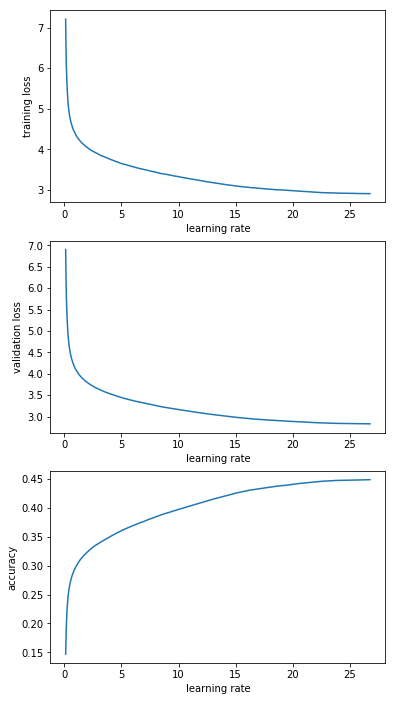

In [132]:
learn.sched.plot()

In [133]:
lr=10
lrs = lr

In [134]:
learn.clip=0.12

In [135]:
learn.fit(lr, 1, cycle_len=10, use_clr_beta=(10,33,0.95,0.85), best_save_name='lm1_wgts')

epoch      trn_loss   val_loss   accuracy                 
    0      5.483585   4.097488   0.289641  
    1      4.501842   3.47113    0.349571                 
    2      3.974504   3.137627   0.400979                 
    3      3.564661   2.893672   0.437043                 
    4      3.22275    2.697126   0.477264                 
    5      2.93172    2.55661    0.501883                 
    6      2.693727   2.483475   0.518388                 
    7      2.531999   2.439067   0.528809                 
    8      2.413343   2.411675   0.531815                 
    9      2.329983   2.410862   0.532077                 


[array([2.41086]), 0.5320771915071151]

In [136]:
learn.load('lm1_wgts')
learn.save_encoder('lm1_enc')

## Classifier tokens

In [137]:
chunksize=24000

re1 = re.compile(r'  +')

In [138]:
df_trn = pd.read_csv(CLAS_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(CLAS_PATH/'validation.csv', header=None, chunksize=chunksize)

In [139]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

In [140]:
(CLAS_PATH/'tmp').mkdir(exist_ok=True)

In [141]:
np.save(CLAS_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(CLAS_PATH/'tmp'/'tok_val.npy', tok_val)

In [142]:
np.save(CLAS_PATH/'tmp'/'trn_labels.npy', trn_labels)
np.save(CLAS_PATH/'tmp'/'val_labels.npy', val_labels)

In [143]:
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')

In [144]:
itos = pickle.load((TWEETSLM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

3746

In [145]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])

In [146]:
np.save(CLAS_PATH/'tmp'/'trn_ids.npy', trn_clas)
np.save(CLAS_PATH/'tmp'/'val_ids.npy', val_clas)

## Classifier

In [147]:
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')

In [148]:
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))

In [149]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 48

In [150]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1

In the classifier, unlike LM, we need to read a tweet at a time. We do not deal with equal bptt size batches, so we have to pad the sequences to the same length in each batch. To create batches of similar sized movie tweets, we use a sortish sampler method invented by [@Smerity](https://twitter.com/Smerity) and [@jekbradbury](https://twitter.com/jekbradbury)

The sortishSampler cuts down the overall number of padding tokens the classifier ends up seeing.

In [151]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(TWEETSLM_PATH, trn_dl, val_dl)

In [152]:
dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.8

In [153]:
m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [155]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [156]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=.12
learn.metrics = [accuracy]

In [157]:
lr=3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [158]:
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

In [159]:
#wd = 1e-7
learn.load_encoder('lm1_enc')

In [160]:
learn.freeze_to(-1)

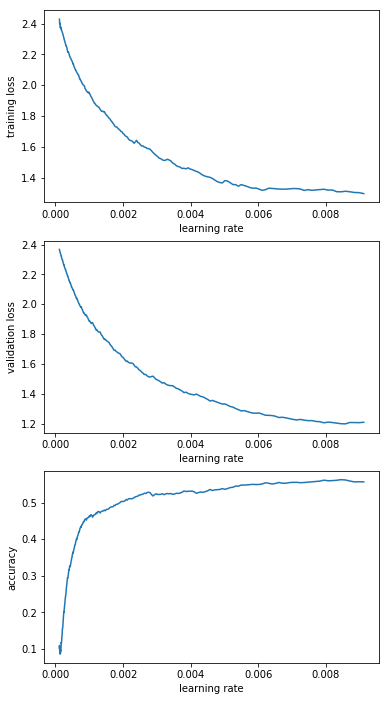

In [166]:
learn.lr_find2(start_lr=1e-4,end_lr=1e-2, num_it=300)
learn.sched.plot()

In [168]:
learn.fit(lrs, 4, wds=wd, cycle_len=1, use_clr_beta=(32,10,0.8,0.7))

epoch      trn_loss   val_loss   accuracy                   
    0      1.201324   1.053453   0.566852  
    1      1.141766   1.036463   0.588819                   
    2      1.134698   1.010546   0.594499                   
    3      1.116511   0.98144    0.60353                    


[array([0.98144]), 0.6035296487171501]

In [169]:
learn.save('clas2_0')

In [170]:
learn.load('clas2_0')

In [171]:
learn.freeze_to(-2)

In [172]:
learn.fit(lrs, 4, wds=wd, cycle_len=1, use_clr_beta=(32,10,0.8,0.7))

epoch      trn_loss   val_loss   accuracy                   
    0      1.05894    0.912675   0.625962  
    1      1.035236   0.881721   0.661143                    
    2      1.040404   0.857452   0.666452                    
    3      0.963715   0.845457   0.675665                    


[array([0.84546]), 0.6756654978682803]

In [173]:
learn.save('clas2_1')

In [174]:
learn.load('clas2_1')

In [175]:
learn.unfreeze()

In [176]:
learn.fit(lr, 2, cycle_len=5, use_clr_beta=(32,10,0.8,0.7), best_save_name='clas2')

epoch      trn_loss   val_loss   accuracy                    
    0      0.839117   0.68079    0.729745  
    1      0.667918   0.526964   0.804977                    
    2      0.600354   0.465169   0.833465                    
    3      0.457055   0.40331    0.850154                    
    4      0.356772   0.380423   0.856148                    
    5      0.310982   0.374055   0.875745                    
    6      0.356482   0.385728   0.867834                    
    7      0.378266   0.392969   0.86573                     
    8      0.280218   0.388532   0.86666                     
    9      0.192572   0.370511   0.870431                    


[array([0.37051]), 0.8704306978500208]

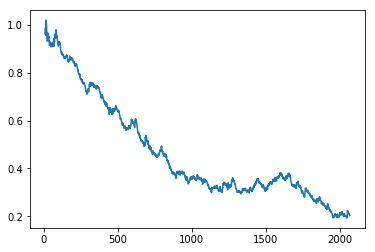

In [177]:
learn.sched.plot_loss()